# <p style="background-color:#6c617d;font-family:newtimeroman;color:#D5CABD;font-size:180%;text-align:center;border-radius:20px 60px;">Traffic Prediction</p>

In this project, I will be exploring the dataset of four junctions and built a model to predict traffic on the same. This could potentially help in solving the traffic congestion problem by providing a better understanding of traffic patterns that will further help in building an infrastructure to eliminate the problem.

<a id='top'></a>

<div class="list-group" id="list-tab" role="tablist">

# <p style="background-color:#6c617d;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">Table Of Contents</p>

- [1. IMPORTING LIBRARIES](#1)
- [2. LOADING DATA](#2)
- [3. DATA EXPLORATION](#3)
  - [3.1 FEATURE ENGINEERING](#3.1)
  - [3.2 EXPLORATORY DATA ANALYSIS](#3.2)
- [4. DATA TRANSFORMATION AND PREPROCESSING](#4)
- [5. MODEL BUILDING](#5)
- [6. FITTING THE MODEL](#6)
- [7. INVERSING THE TRANSFORMATION OF DATA](#7)
- [8. END](#8)


<a id="1"></a>

# <p style="background-color:#6c617d;font-family:newtimeroman;color:#D5CABD;font-size:120%;text-align:center;border-radius:20px 60px;">Importing Libraries</p>


In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import (
    Conv2D,
    Flatten,
    Dense,
    LSTM,
    Dropout,
    GRU,
    Bidirectional,
    Conv1D,
    MaxPooling1D,
)
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import warnings

warnings.filterwarnings("ignore")

Loading data


In [4]:
dataset = pd.read_csv("traffic.csv")
dataset.head()

DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041

In [6]:
data = dataset.copy()

**About the data**

This dataset is a collection of numbers of vehicles at four junctions at an hourly frequency.
The CSV file provides four features:

- DateTime
- Junctions
- Vehicles
- ID

The sensors on each of these junctions were collecting data at different times, hence the traffic data from different time periods. Some of the junctions have provided limited or sparse data.


<a id="3"></a>

# <p style="background-color:#6c617d;font-family:newtimeroman;color:#D5CABD;font-size:120%;text-align:center;border-radius:20px 60px;">Data Exploration</p>

- Pharsing dates
- Ploting timeseris
- Feature engineering for EDA


In [7]:
data["DateTime"] = pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1)  # dropping IDs
data.info

<bound method DataFrame.info of                  DateTime  Junction  Vehicles
0     2015-11-01 00:00:00         1        15
1     2015-11-01 01:00:00         1        13
2     2015-11-01 02:00:00         1        10
3     2015-11-01 03:00:00         1         7
4     2015-11-01 04:00:00         1         9
...                   ...       ...       ...
48115 2017-06-30 19:00:00         4        11
48116 2017-06-30 20:00:00         4        30
48117 2017-06-30 21:00:00         4        16
48118 2017-06-30 22:00:00         4        22
48119 2017-06-30 23:00:00         4        12

[48120 rows x 3 columns]>

Text(0.5, 0, 'Date')

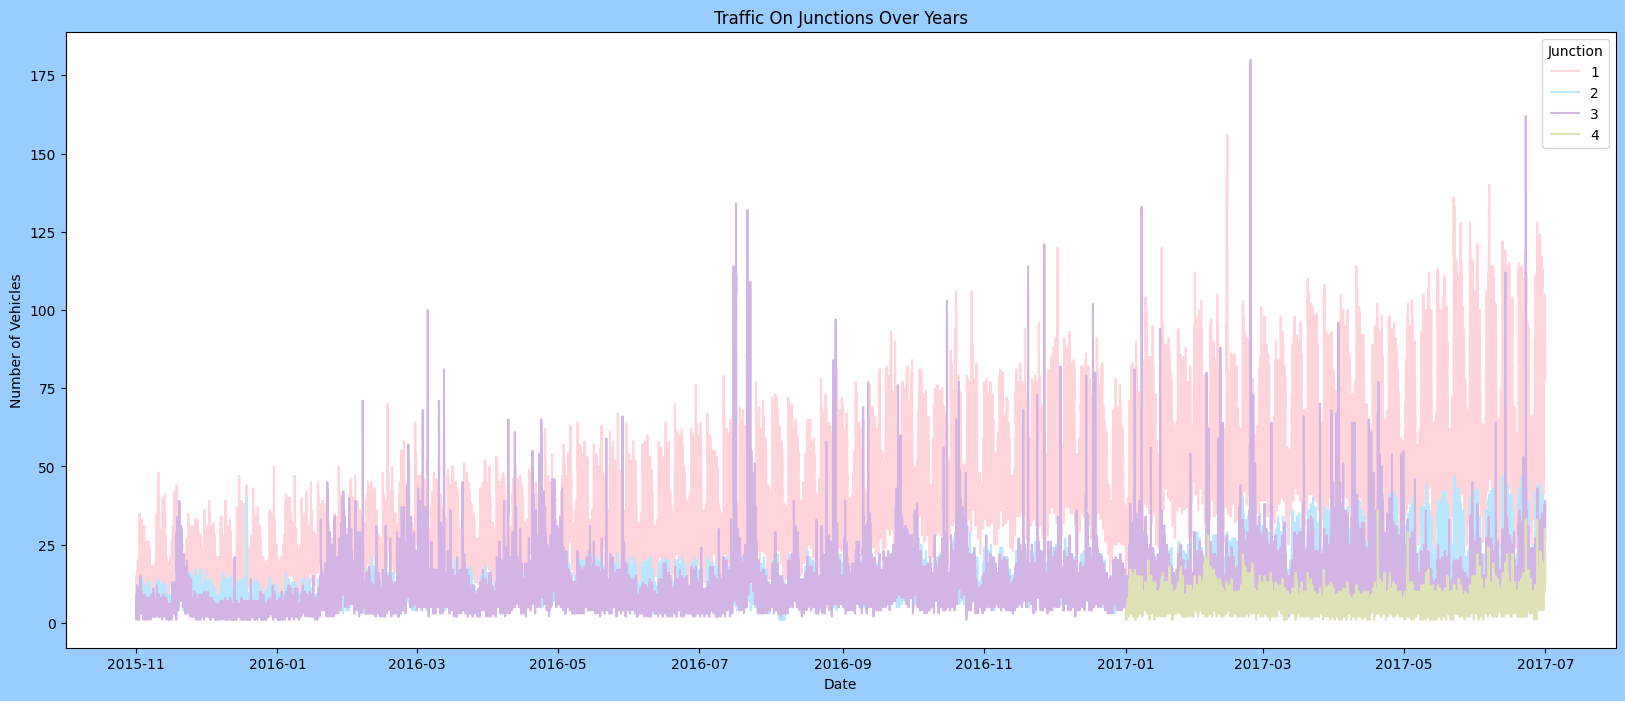

In [8]:
# df to be used for EDA
df = data.copy()

# Plot the Timeseries
colors = ["#FFD4DB", "#BBE7FE", "#D3B5E5", "#dfe2b6"]
plt.figure(figsize=(20, 8), facecolor="#99ccff")
Time_series = sns.lineplot(
    x=df["DateTime"], y="Vehicles", data=df, hue="Junction", palette=colors
)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

**Noticeable information in the above plot:**

- It can be seen here that the first junction is visibly having an upward trend.
- The data for the fourth junction is sparse starting only after 2017
- Seasonality is not evident from the above plot, So we must explore datetime composition to figure out more about it.


<a id="3.1"></a>

# <p style="background-color:#6c617d;font-family:newtimeroman;color:#D5CABD;font-size:120%;text-align:center;border-radius:20px 60px;">Feature Engineering</p>

At this step, I am creating a few new features out of DateTime.
Namely:

- Year
- Month
- Date in the given month
- Days of week
- Hour


In [9]:
# Exploring more features
df["Year"] = df["DateTime"].dt.year
df["Month"] = df["DateTime"].dt.month
df["Date_no"] = df["DateTime"].dt.day
df["Hour"] = df["DateTime"].dt.hour
df["Day"] = df.DateTime.dt.strftime("%A")
df.head()

DateTime  Junction  Vehicles  Year  Month  Date_no  Hour     Day
0 2015-11-01 00:00:00         1        15  2015     11        1     0  Sunday
1 2015-11-01 01:00:00         1        13  2015     11        1     1  Sunday
2 2015-11-01 02:00:00         1        10  2015     11        1     2  Sunday
3 2015-11-01 03:00:00         1         7  2015     11        1     3  Sunday
4 2015-11-01 04:00:00         1         9  2015     11        1     4  Sunday

<a id="3.2"></a>

# <p style="background-color:#6c617d;font-family:newtimeroman;color:#D5CABD;font-size:120%;text-align:center;border-radius:20px 60px;">Exploratory Data Analysis</p>

Plotting the newly created features


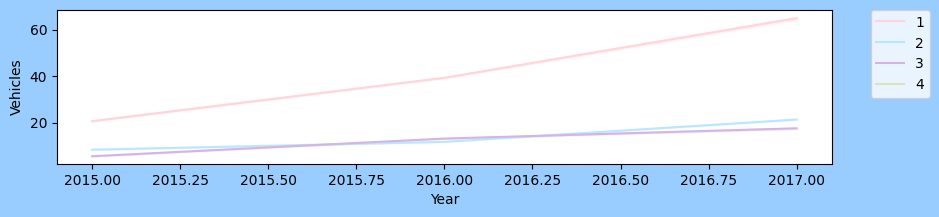

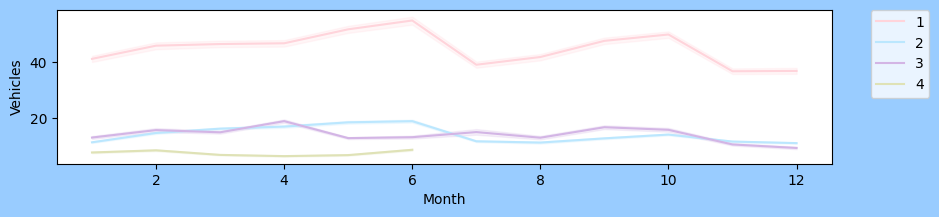

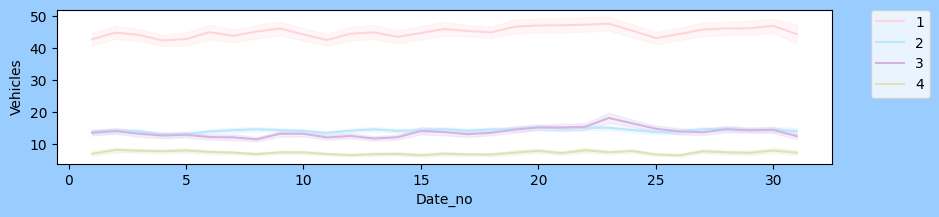

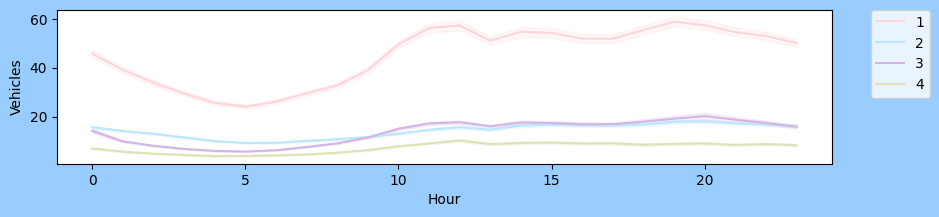

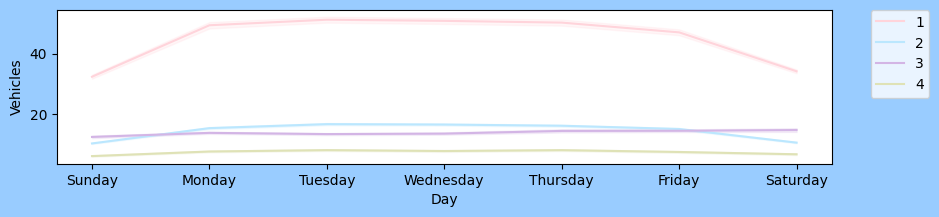

In [10]:
# Let's plot the Timeseries
new_features = ["Year", "Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10, 2), facecolor="#99ccff")
    ax = sns.lineplot(x=df[i], y="Vehicles", data=df, hue="Junction", palette=colors)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

**From the above plot following things can be concluded:**

- Yearly, there has been an upward trend for all junctions except for the fourth junction. As we already established above that the fourth junction has limited data and that don't span over a year.

- We can see that there is an influx in the first and second junctions around June. I presume this may be due to summer break and activities around the same.

- Monthly, throughout all the dates there is a good consistency in data.

- For a day, we can see that are peaks during morning and evening times and a decline during night hours. This is as per expectation.

- For weekly patterns, Sundays enjoy smoother traffic as there are lesser vehicles on roads. Whereas Monday to Friday the traffic is steady.


Text(0.5, 0, 'Date')

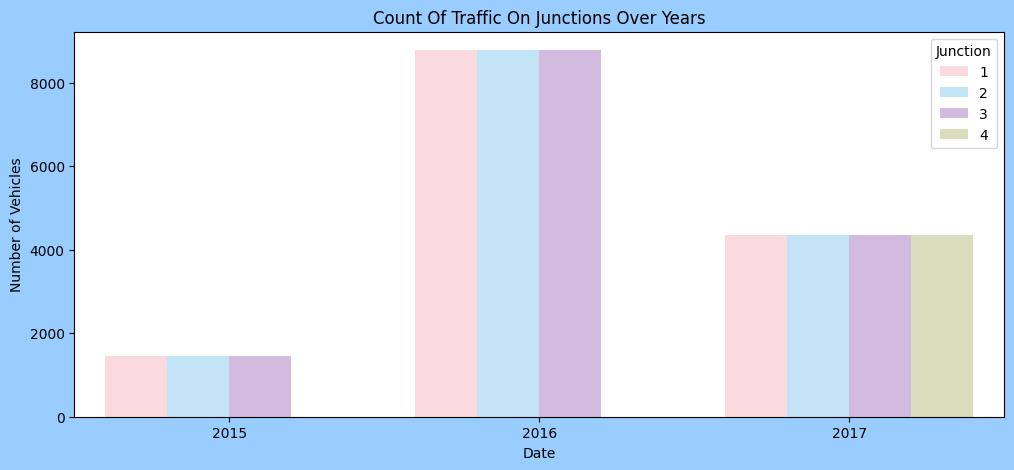

In [11]:
plt.figure(figsize=(12, 5), facecolor="#99ccff")
count = sns.countplot(data=df, x=df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

The count plot shows that there is an increase in the number of vehicles between 2015 and 2016. However, it is inconclusive to say the same about 2017 as we have limited data for 2017 (i.e. till the 7th month).


<Axes: >

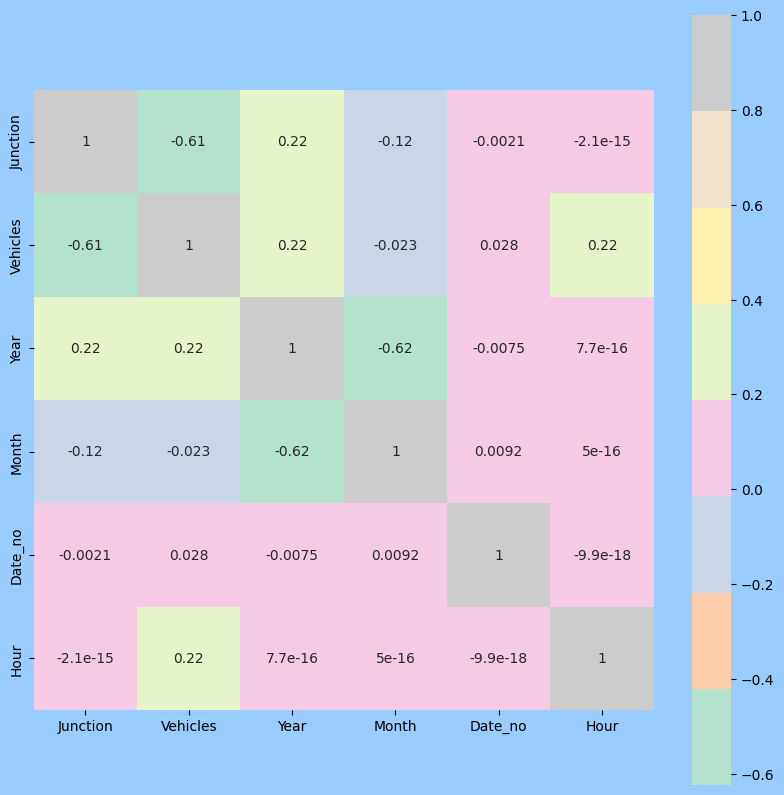

In [12]:
# Select only numeric dtypes
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corrmat = numeric_df.corr()

# Plot heatmap
plt.subplots(figsize=(10, 10), facecolor="#99ccff")
sns.heatmap(corrmat, cmap="Pastel2", annot=True, square=True)

The highest correlation is certainly with the preexisting feature.

I will conclude my EDA with a pair plot. It's an interesting overall representation of any data.


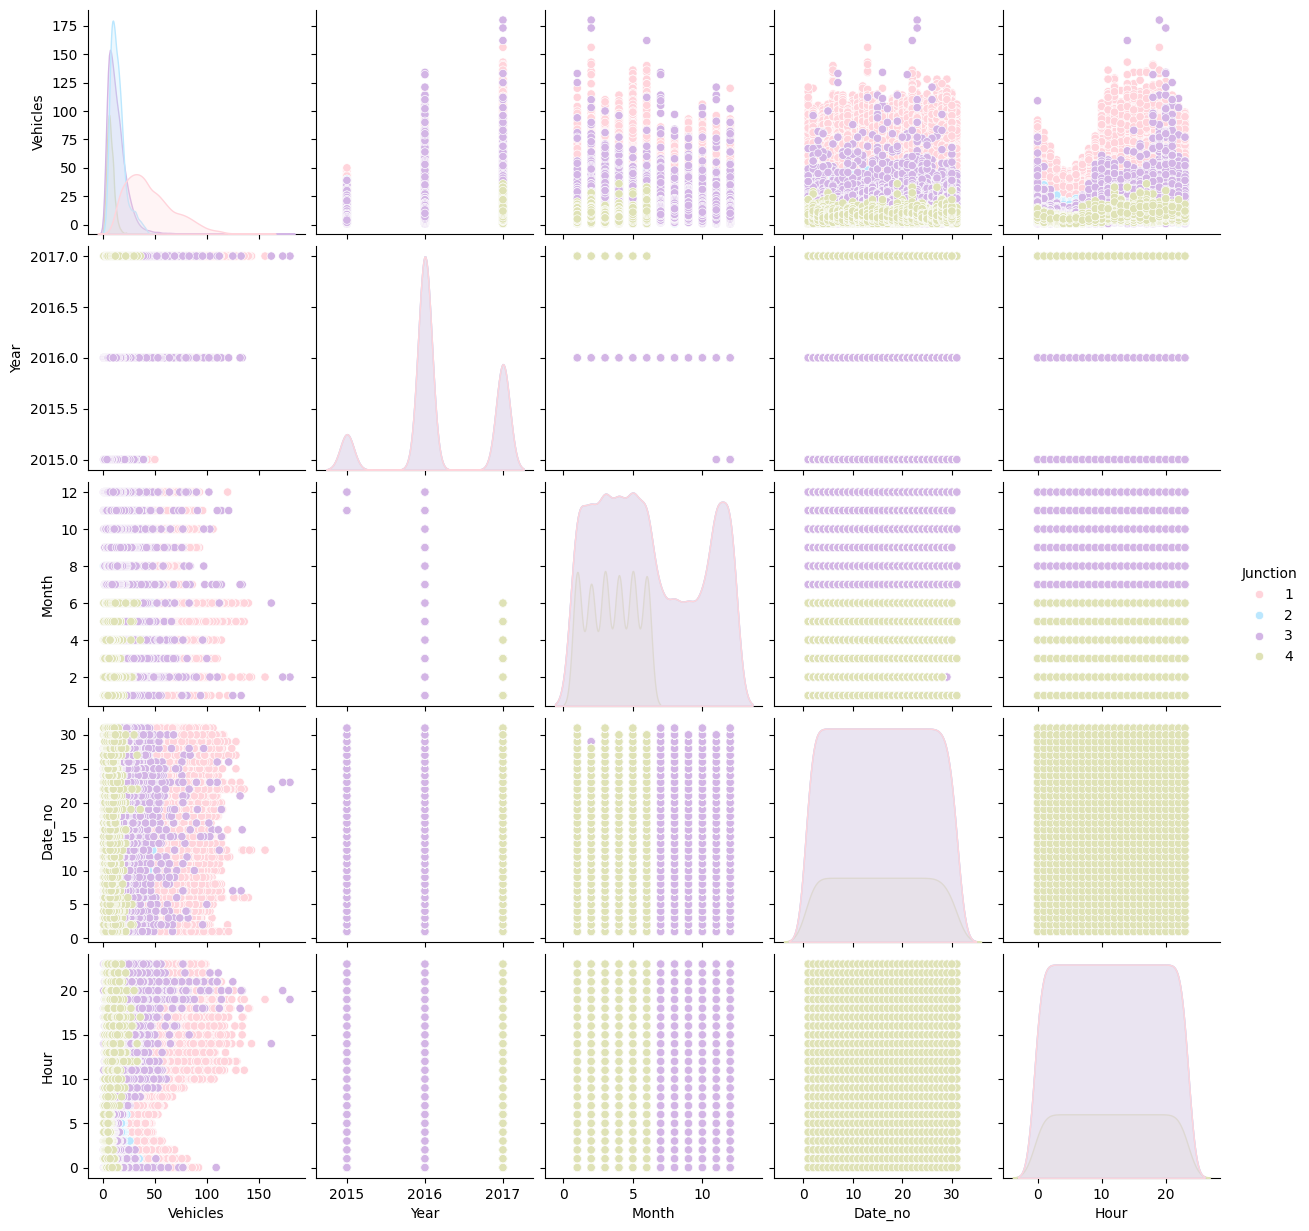

In [13]:
sns.pairplot(data=df, hue="Junction", palette=colors)

**Conclusions that I have come to draw after this EDA**

- The span of data from all four junctions is not the same. Data provided for the fourth junction is limited to only 2017.
- The yearly trend for Junctions one, two and three have diffrent slopes.
- Junction number one has a more strong weekly seasonality in comparison to the other junctions.

For the above-postulated reasons, I think that junctions must be transformed as per their individual needs.


# Data Transformation And Preprocessing

**In this step I will be following the subsequent order:**

- Creating different frames for each Junction and plotting them
- Transforming the series and plotting them
- Performing the Augmented Dickey-Fuller test to check the seasonality of transformed series
- Creating test and train sets


In [16]:
# Pivoting data fron junction
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

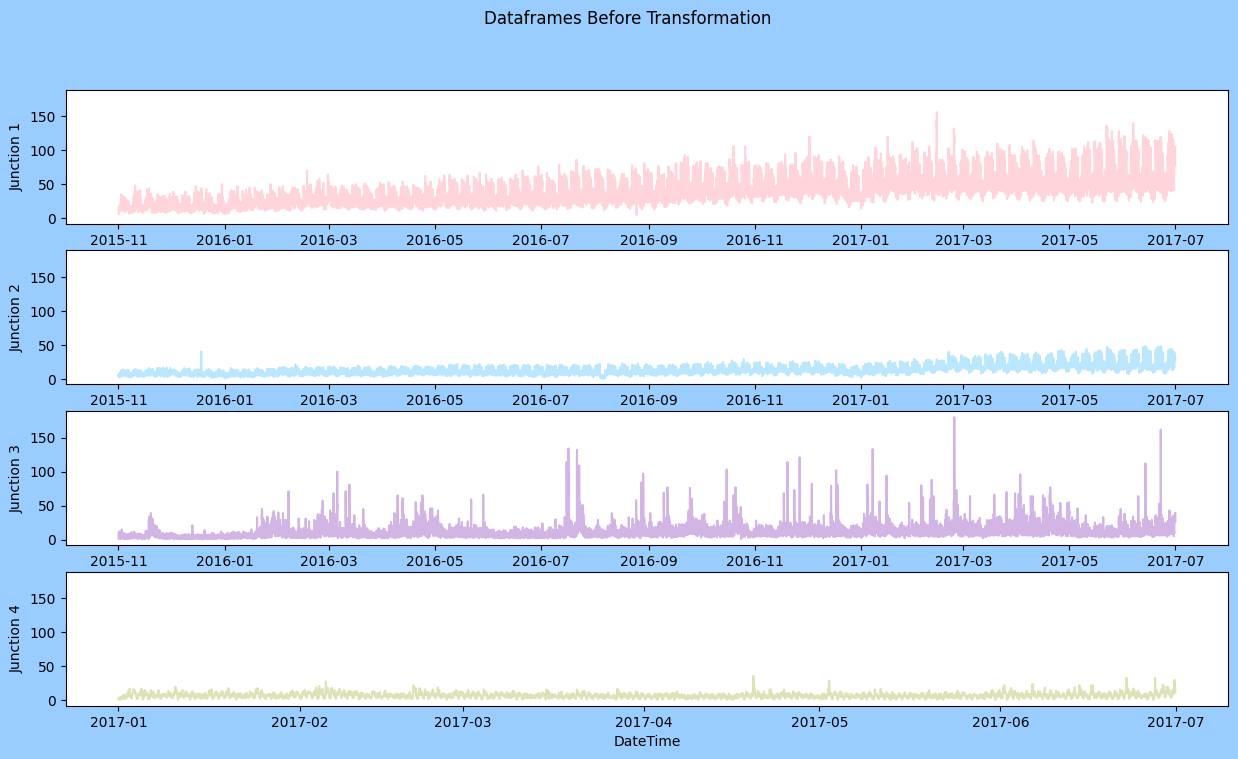

In [17]:
# Creating new sets
df_1 = df_J[[("Vehicles", 1)]]
df_2 = df_J[[("Vehicles", 2)]]
df_3 = df_J[[("Vehicles", 3)]]
df_4 = df_J[[("Vehicles", 4)]]
df_4 = df_4.dropna()  # Junction 4 has limited data only for a few months

# Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns = i.columns.droplevel(level=1)


# Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2, df_3, df_4, title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8), facecolor="#99ccff", sharey=True)
    fig.suptitle(title)
    # J1
    pl_1 = sns.lineplot(ax=axes[0], data=df_1, color=colors[0])
    # pl_1=plt.ylabel()
    axes[0].set(ylabel="Junction 1")
    # J2
    pl_2 = sns.lineplot(ax=axes[1], data=df_2, color=colors[1])
    axes[1].set(ylabel="Junction 2")
    # J3
    pl_3 = sns.lineplot(ax=axes[2], data=df_3, color=colors[2])
    axes[2].set(ylabel="Junction 3")
    # J4
    pl_4 = sns.lineplot(ax=axes[3], data=df_4, color=colors[3])
    axes[3].set(ylabel="Junction 4")


# Plotting the dataframe to check for stationarity
Sub_Plots4(
    df_1.Vehicles,
    df_2.Vehicles,
    df_3.Vehicles,
    df_4.Vehicles,
    "Dataframes Before Transformation",
)

A time series is stationary if it does not have a trend or seasonality. However, in the EDA, we saw a weekly seasonality and an upwards trend over the years. In the above plot, it is again established that Junctions one and two have an upward trend. If we limit the span we will be able to further see the weekly seasonality. I will be spairing that step at this point and moving on with the respective transforms on datasets.

**Steps for Transforming:**

- Normalizing
- Differencing


In [18]:
# Normalize Function
def Normalize(df, col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev


# Differencing Function
def Difference(df, col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In accordance with the above observations, Differencing to eliminate the seasonality should be performed as follows:

- For Junction one, I will be taking a difference of weekly values.
- For junction two, The difference of consecutive days is a better choice
- For Junctions three and four, the difference of the hourly values will serve the purpose.


In [19]:
# Normalizing and Differencing to make the series stationary
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(
    df_N1, col="Vehicles", interval=(24 * 7)
)  # taking a week's diffrence
df_N1 = df_N1[24 * 7 :]
df_N1.columns = ["Norm"]
df_N1["Diff"] = Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24))  # taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"] = Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1)  # taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"] = Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1)  # taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"] = Diff_4

**Plots of Transformed Dataframe**


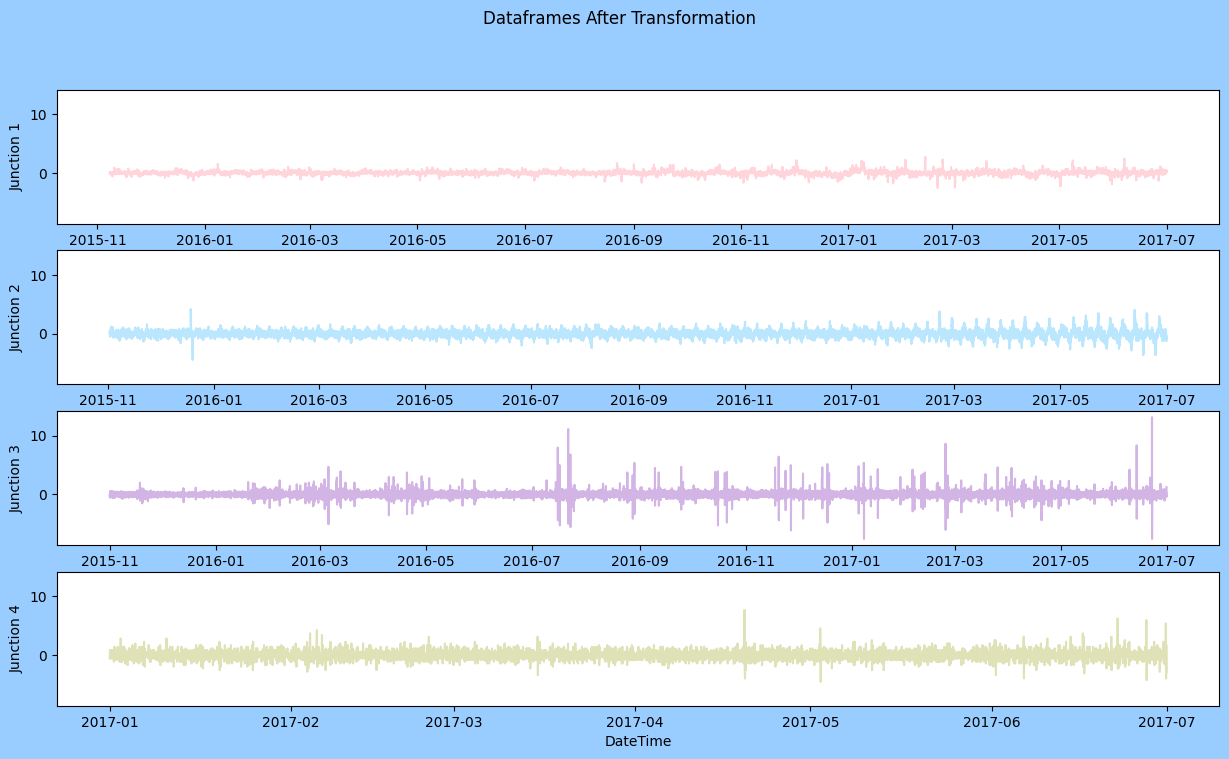

In [20]:
Sub_Plots4(
    df_N1.Diff, df_N2.Diff, df_N3.Diff, df_N4.Diff, "Dataframes After Transformation"
)

The plots above seem linear. To ensure they are Stationary I will be performing an Augmented Dickey-Fuller test.


In [21]:
# Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print("\t%s: %.3f" % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


# Checking if the series is stationary

List_df_ND = [df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415355
p-value: 4.798539876397885e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940073
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832597
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305218
p-value: 2.7787875325956593e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


**Now that the data is stationary, preprocessing the data for the neural net by:**

- Splitting the test train sets
- Assigning X as features and y as target
- Reshaping data for neural net


In [22]:
# Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()


# Splitting the dataset
def Split_data(df):
    training_size = int(len(df) * 0.90)
    data_len = len(df)
    train, test = df[0:training_size], df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test


# Splitting the training and test datasets
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)


# Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps : i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X, y


# fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0], test.shape[1], 1))
    return train, test


# Assigning features and target
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

# Building model

For this project, I use Gated Recurrent Unit (GRU). In this section, I am creating a function for the neural net to call on and fit the data frames for all four junctions.


In [23]:
# Custom Layer
class CustomLayer(layers.Layer):
    def __init__(self, units=32):
        super(CustomLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [24]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9
)


# Custom_Model for the prediction
def Custom_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(
        min_delta=0.001, patience=10, restore_best_weights=True
    )
    model = Sequential()
    model.add(
        layers.Flatten(input_shape=(X_Train.shape[1], X_Train.shape[2]))
    )  # Flatten layer
    model.add(Dense(150, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.2))
    model.add(CustomLayer(50))  # Custom layer
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(
        optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),
        loss="mean_squared_error",
    )
    model.fit(
        X_Train,
        y_Train,
        validation_data=(X_Test, y_Test),
        epochs=50,
        batch_size=120,
        callbacks=[early_stopping],
    )
    pred_Custom = model.predict(X_Test)
    return pred_Custom


# GRU Model for the prediction
def GRU_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(
        min_delta=0.001, patience=10, restore_best_weights=True
    )
    # callback delta 0.01 may interrupt the learning.

    # The GRU model
    model = Sequential()
    model.add(
        GRU(
            units=150,
            return_sequences=True,
            input_shape=(X_Train.shape[1], 1),
            activation="tanh",
        )
    )
    model.add(Dropout(0.2))
    model.add(
        GRU(
            units=150,
            return_sequences=True,
            input_shape=(X_Train.shape[1], 1),
            activation="tanh",
        )
    )
    model.add(Dropout(0.2))
    model.add(
        GRU(
            units=50,
            return_sequences=True,
            input_shape=(X_Train.shape[1], 1),
            activation="tanh",
        )
    )
    model.add(Dropout(0.2))
    model.add(
        GRU(
            units=50,
            return_sequences=True,
            input_shape=(X_Train.shape[1], 1),
            activation="tanh",
        )
    )
    model.add(Dropout(0.2))
    # model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    # model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1], 1), activation="tanh"))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Compiling the model
    model.compile(
        optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),
        loss="mean_squared_error",
    )
    model.fit(
        X_Train,
        y_Train,
        validation_data=(X_Test, y_Test),
        epochs=50,
        batch_size=120,
        callbacks=[early_stopping],
    )
    pred_GRU = model.predict(X_Test)
    return pred_GRU


# LSTM Model for the prediction
def LSTM_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(
        min_delta=0.001, patience=10, restore_best_weights=True
    )

    # The LSTM model
    model = Sequential()
    model.add(
        LSTM(
            units=150,
            return_sequences=True,
            input_shape=(X_Train.shape[1], 1),
            activation="tanh",
        )
    )
    model.add(Dropout(0.2))
    model.add(
        LSTM(
            units=150,
            return_sequences=True,
            input_shape=(X_Train.shape[1], 1),
            activation="tanh",
        )
    )
    model.add(Dropout(0.2))
    model.add(
        LSTM(
            units=50,
            return_sequences=True,
            input_shape=(X_Train.shape[1], 1),
            activation="tanh",
        )
    )
    model.add(Dropout(0.2))
    model.add(
        LSTM(
            units=50,
            return_sequences=True,
            input_shape=(X_Train.shape[1], 1),
            activation="tanh",
        )
    )
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, input_shape=(X_Train.shape[1], 1), activation="tanh"))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Compiling the model
    model.compile(
        optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),
        loss="mean_squared_error",
    )
    model.fit(
        X_Train,
        y_Train,
        validation_data=(X_Test, y_Test),
        epochs=50,
        batch_size=120,
        callbacks=[early_stopping],
    )
    pred_LSTM = model.predict(X_Test)
    return pred_LSTM


# CNN Model for the prediction
def CNN_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(
        min_delta=0.001, patience=10, restore_best_weights=True
    )

    # The CNN model
    model = Sequential()
    model.add(
        Conv1D(
            filters=64,
            kernel_size=3,
            activation="relu",
            input_shape=(X_Train.shape[1], 1),
        )
    )
    model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation="relu"))
    model.add(Dense(units=1))

    # Compiling the model
    model.compile(
        optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),
        loss="mean_squared_error",
    )
    model.fit(
        X_Train,
        y_Train,
        validation_data=(X_Test, y_Test),
        epochs=50,
        batch_size=120,
        callbacks=[early_stopping],
    )
    pred_CNN = model.predict(X_Test)
    return pred_CNN


# MLP Model for the prediction
def MLP_model(X_Train, y_Train, X_Test, y_Test):
    X_Train = np.squeeze(X_Train)  # This line removes the unnecessary dimension
    X_Test = np.squeeze(X_Test)  # Do the same for the test data
    early_stopping = callbacks.EarlyStopping(
        min_delta=0.001, patience=10, restore_best_weights=True
    )
    model = Sequential()
    model.add(Dense(150, activation="relu", input_dim=X_Train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(150, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(
        optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),
        loss="mean_squared_error",
    )
    model.fit(
        X_Train,
        y_Train,
        validation_data=(X_testJ1, y_testJ1),
        epochs=50,
        batch_size=120,
        callbacks=[early_stopping],
    )
    pred_MLP = model.predict(X_Test)
    return pred_MLP


# To calculate the root mean squred error in predictions
def RMSE_Value(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse


# To plot the comparitive plot of targets and predictions
def PredictionsPlot(test, predicted, m):
    plt.figure(figsize=(12, 5), facecolor="#99ccff")
    plt.plot(test, color=colors[m], label="True Value", alpha=0.5)
    plt.plot(predicted, color="#627D78", label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

<a id="6"></a>

# <p style="background-color:#6c617d;font-family:newtimeroman;color:#D5CABD;font-size:120%;text-align:center;border-radius:20px 60px;">Fitting The Model</p>

Now, I will be fitting the transformed training sets of four junctions to the model created and compare them to the transformed test sets.

**Fitting the first junction and plotting the predictions and testset**


In [25]:
# Predictions For First Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ1_Custom = Custom_model(X_trainJ1, y_trainJ1, X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ1_GRU = GRU_model(X_trainJ1, y_trainJ1, X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ1_LSTM = LSTM_model(X_trainJ1, y_trainJ1, X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ1_CNN = CNN_model(X_trainJ1, y_trainJ1, X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ1_MLP = MLP_model(X_trainJ1, y_trainJ1, X_testJ1, y_testJ1)
print("-" * 70)

########------Custom Model------########

Epoch 1/50

108/108 [==============================] - 2s 6ms/step - loss: 0.0706 - val_loss: 0.0750
Epoch 2/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0565 - val_loss: 0.0654
Epoch 3/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0543 - val_loss: 0.0637
Epoch 4/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0514 - val_loss: 0.0626
Epoch 5/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0509 - val_loss: 0.0613
Epoch 6/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0497 - val_loss: 0.0612
Epoch 7/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0497 - val_loss: 0.0600
Epoch 8/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0485 - val_loss: 0.0602
Epoch 9/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0486 - val_loss: 0.0598
Epoch 10/50
108/108 [==============================] - 1s

########------Custom Model------########
The root mean squared error is 0.24291990230386898.


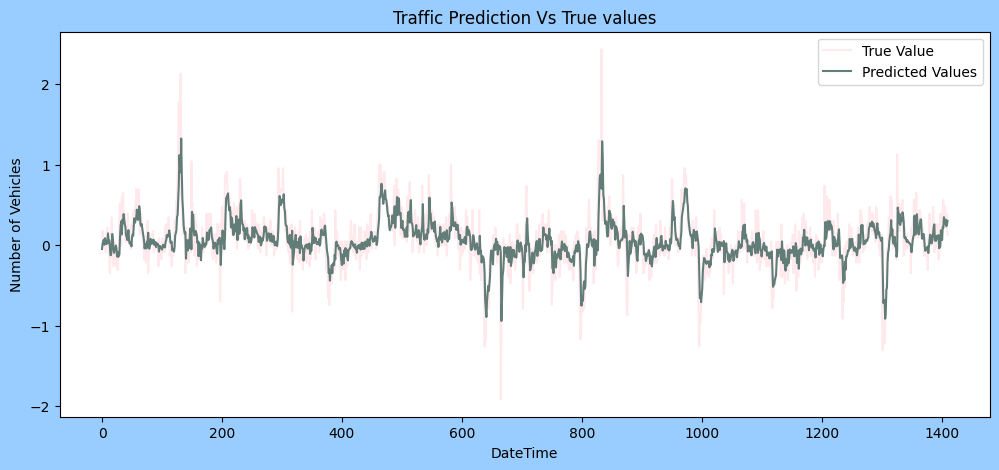

########------GRU Model------########
The root mean squared error is 0.24652774517567005.


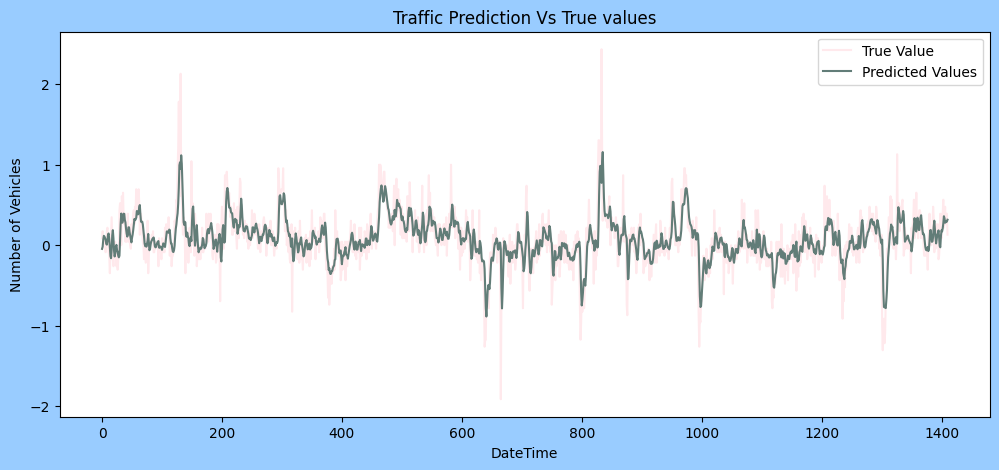


########------LSTM Model------########
The root mean squared error is 0.27319689413027354.


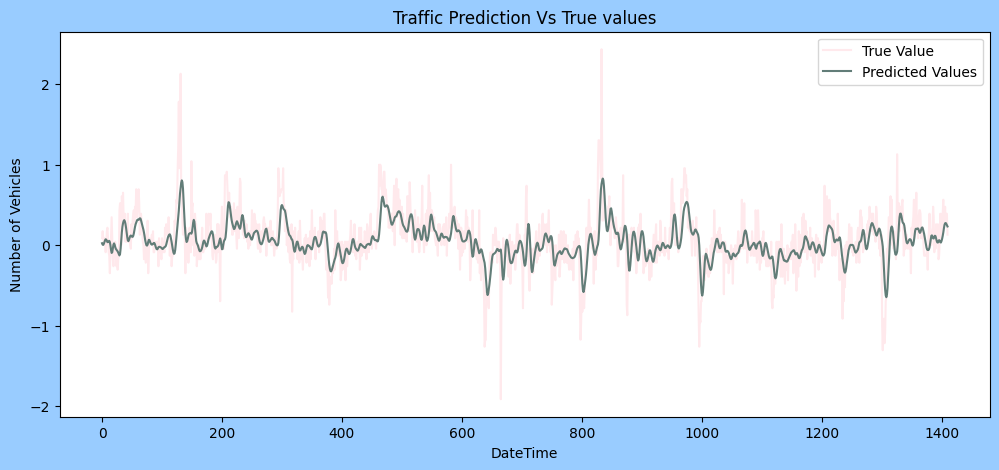


########------CNN Model------########
The root mean squared error is 0.24520611806287604.


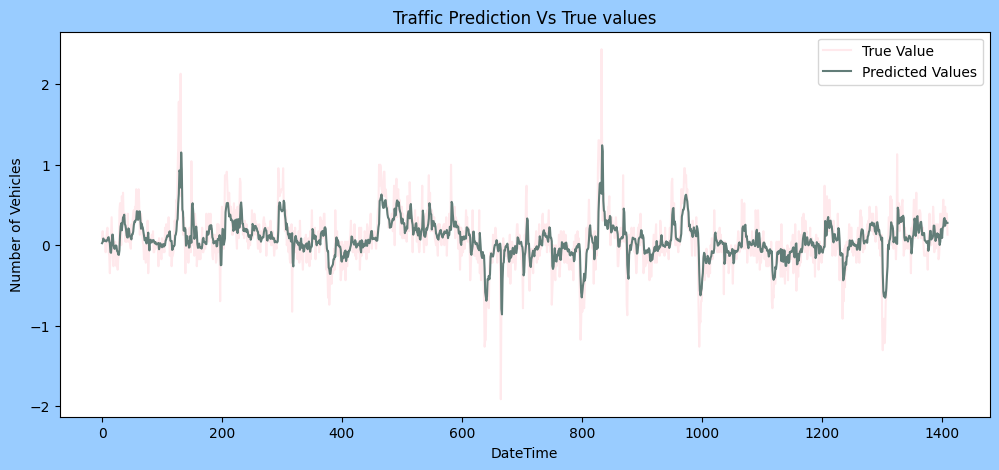


########------MLP Model------########
The root mean squared error is 0.2457699773400752.


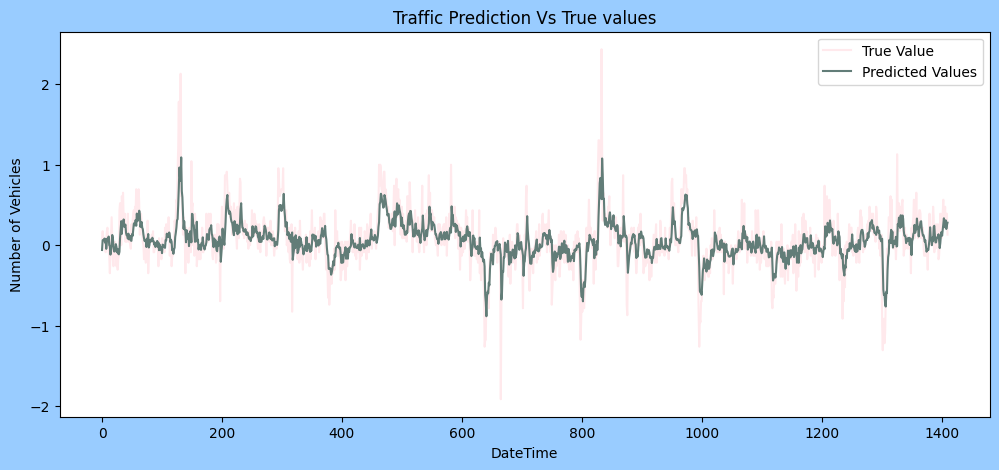


Best Model: Custom - RMSE: 0.24291990230386898



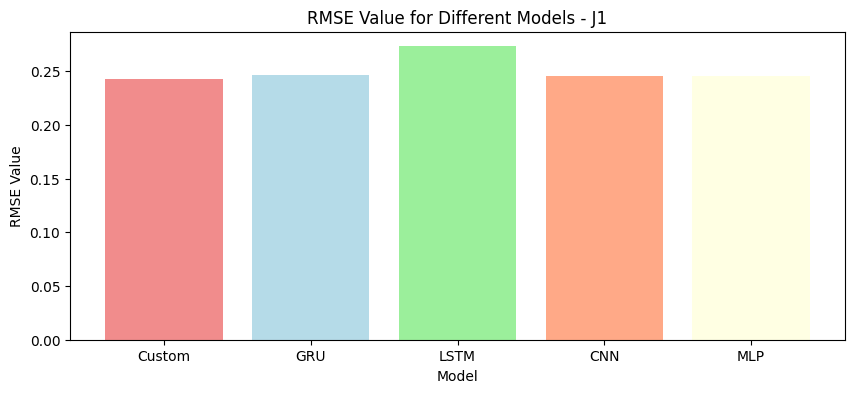

In [26]:
# Results for J1 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J1_Custom = RMSE_Value(y_testJ1, PredJ1_Custom)
PredictionsPlot(y_testJ1, PredJ1_Custom, 0)

# Results for J1 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J1_GRU = RMSE_Value(y_testJ1, PredJ1_GRU)
PredictionsPlot(y_testJ1, PredJ1_GRU, 0)

# Results for J1 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J1_LSTM = RMSE_Value(y_testJ1, PredJ1_LSTM)
PredictionsPlot(y_testJ1, PredJ1_LSTM, 0)

# Results for J1 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J1_CNN = RMSE_Value(y_testJ1, PredJ1_CNN)
PredictionsPlot(y_testJ1, PredJ1_CNN, 0)

# Results for J1 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J1_MLP = RMSE_Value(y_testJ1, PredJ1_MLP)
PredictionsPlot(y_testJ1, PredJ1_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J1_Custom, RMSE_J1_GRU, RMSE_J1_LSTM, RMSE_J1_CNN, RMSE_J1_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_1 = model_names[best_model_index]
best_model_rmse_1 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print(
    "\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(
        best_model_name_1, best_model_rmse_1
    )
)

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ["lightcoral", "lightblue", "lightgreen", "lightsalmon", "lightyellow"]
alpha = 0.9
fig, ax = plt.subplots(figsize=(10, 4))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel("Model")
ax.set_ylabel("RMSE Value")
ax.set_title("RMSE Value for Different Models - J1")
plt.show()

display(styled_df)

In [27]:
# Predictions For Second Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ2_Custom = Custom_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ2_GRU = GRU_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ2_LSTM = LSTM_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ2_CNN = CNN_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ2_MLP = MLP_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)

########------Custom Model------########
Epoch 1/50
109/109 [==============================] - 1s 4ms/step - loss: 0.2193 - val_loss: 0.2817
Epoch 2/50
109/109 [==============================] - 0s 3ms/step - loss: 0.1703 - val_loss: 0.2792
Epoch 3/50
109/109 [==============================] - 0s 3ms/step - loss: 0.1622 - val_loss: 0.2444
Epoch 4/50
109/109 [==============================] - 0s 3ms/step - loss: 0.1549 - val_loss: 0.2473
Epoch 5/50
109/109 [==============================] - 0s 3ms/step - loss: 0.1500 - val_loss: 0.2280
Epoch 6/50
109/109 [==============================] - 0s 3ms/step - loss: 0.1487 - val_loss: 0.2345
Epoch 7/50
109/109 [==============================] - 0s 3ms/step - loss: 0.1459 - val_loss: 0.2316
Epoch 8/50
109/109 [==============================] - 0s 3ms/step - loss: 0.1467 - val_loss: 0.2282
Epoch 9/50
109/109 [==============================] - 0s 3ms/step - loss: 0.1444 - val_loss: 0.2370
Epoch 10/50
109/109 [==============================] - 0s 3

########------Custom Model------########
The root mean squared error is 0.4675440791775241.


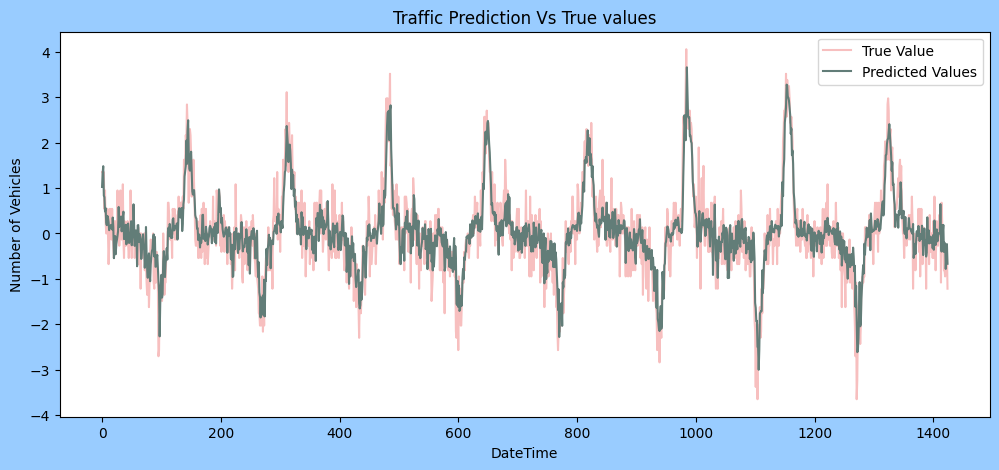

########------GRU Model------########
The root mean squared error is 0.555016260270446.


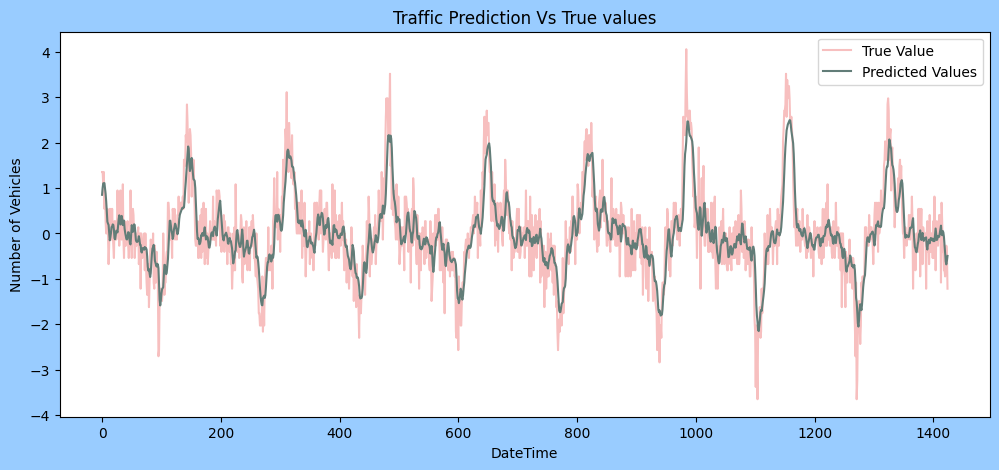


########------LSTM Model------########
The root mean squared error is 0.5735069289898584.


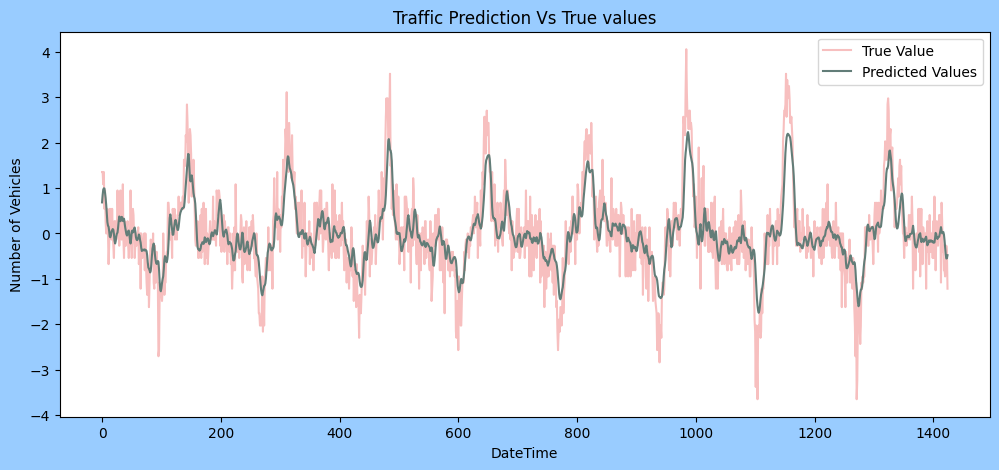


########------CNN Model------########
The root mean squared error is 0.5513778950428163.


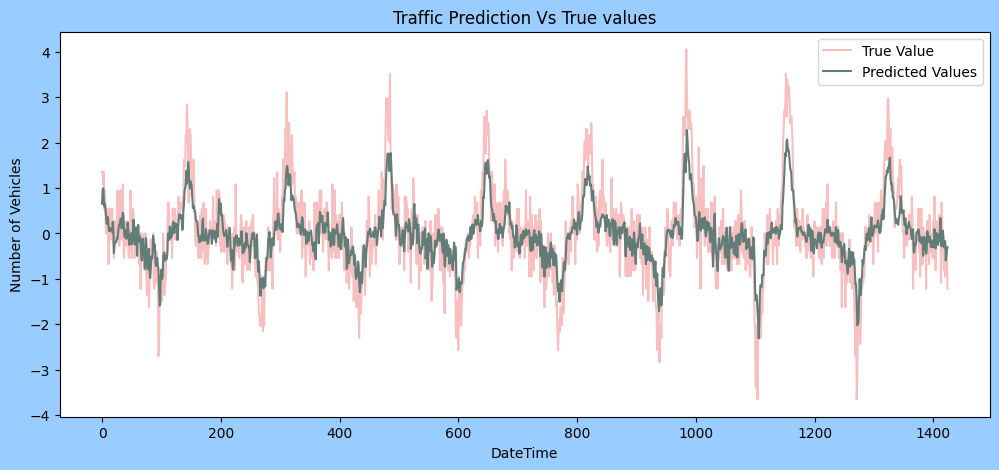


########------MLP Model------########
The root mean squared error is 0.5343114531894261.


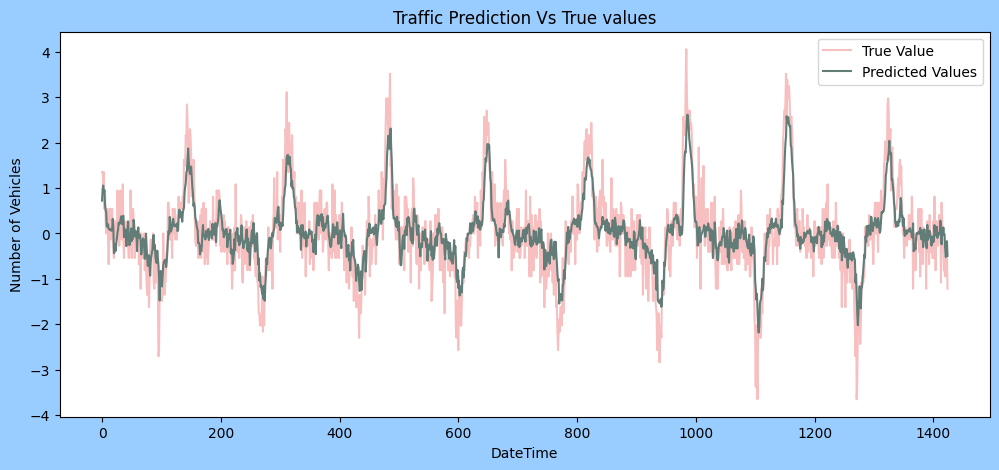


Best Model: Custom - RMSE: 0.4675440791775241



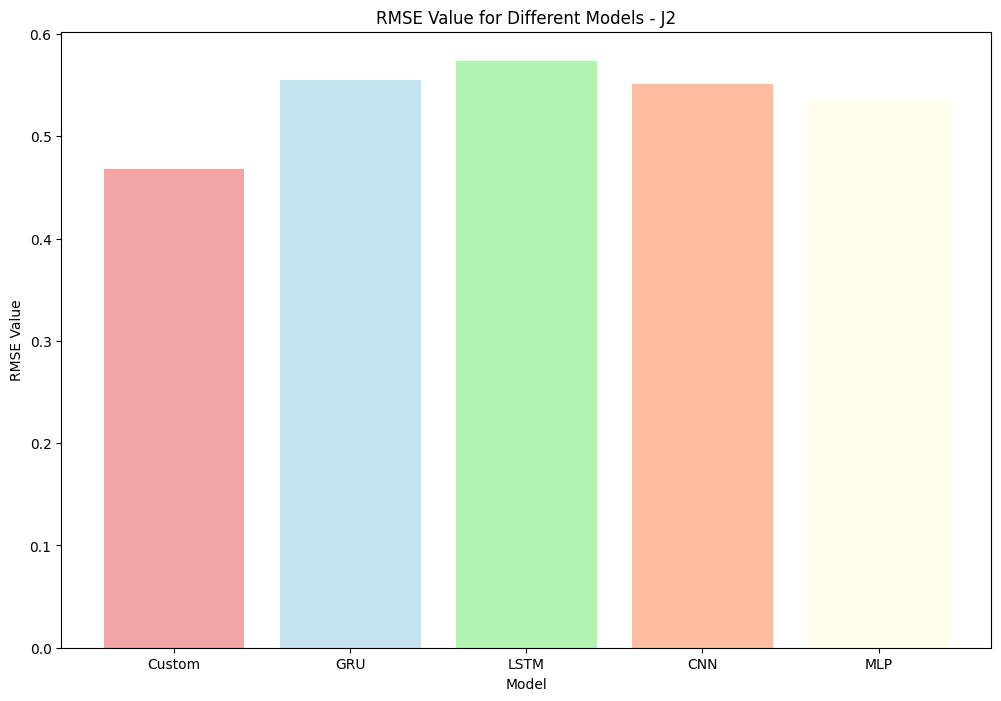

In [28]:
# Results for J2 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J2_Custom = RMSE_Value(y_testJ2, PredJ2_Custom)
PredictionsPlot(y_testJ2, PredJ2_Custom, 0)

# Results for J2 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J2_GRU = RMSE_Value(y_testJ2, PredJ2_GRU)
PredictionsPlot(y_testJ2, PredJ2_GRU, 0)

# Results for J2 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J2_LSTM = RMSE_Value(y_testJ2, PredJ2_LSTM)
PredictionsPlot(y_testJ2, PredJ2_LSTM, 0)

# Results for J2 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J2_CNN = RMSE_Value(y_testJ2, PredJ2_CNN)
PredictionsPlot(y_testJ2, PredJ2_CNN, 0)

# Results for J2 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J2_MLP = RMSE_Value(y_testJ2, PredJ2_MLP)
PredictionsPlot(y_testJ2, PredJ2_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J2_Custom, RMSE_J2_GRU, RMSE_J2_LSTM, RMSE_J2_CNN, RMSE_J2_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_2 = model_names[best_model_index]
best_model_rmse_2 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print(
    "\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(
        best_model_name_2, best_model_rmse_2
    )
)

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ["lightcoral", "lightblue", "lightgreen", "lightsalmon", "lightyellow"]
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel("Model")
ax.set_ylabel("RMSE Value")
ax.set_title("RMSE Value for Different Models - J2")
plt.show()

display(styled_df)

In [29]:
# Predictions For Third Junction
# Predictions For Third Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ3_Custom = Custom_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ3_GRU = GRU_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ3_LSTM = LSTM_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ3_CNN = CNN_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ3_MLP = MLP_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)

########------Custom Model------########
Epoch 1/50
110/110 [==============================] - 1s 4ms/step - loss: 0.2972 - val_loss: 0.3708
Epoch 2/50
110/110 [==============================] - 0s 3ms/step - loss: 0.2842 - val_loss: 0.3578
Epoch 3/50
110/110 [==============================] - 0s 3ms/step - loss: 0.2707 - val_loss: 0.3442
Epoch 4/50
110/110 [==============================] - 0s 3ms/step - loss: 0.2572 - val_loss: 0.3476
Epoch 5/50
110/110 [==============================] - 0s 3ms/step - loss: 0.2558 - val_loss: 0.3472
Epoch 6/50
110/110 [==============================] - 0s 3ms/step - loss: 0.2561 - val_loss: 0.3438
Epoch 7/50
110/110 [==============================] - 0s 3ms/step - loss: 0.2454 - val_loss: 0.3351
Epoch 8/50
110/110 [==============================] - 0s 3ms/step - loss: 0.2431 - val_loss: 0.3313
Epoch 9/50
110/110 [==============================] - 0s 3ms/step - loss: 0.2430 - val_loss: 0.3394
Epoch 10/50
110/110 [==============================] - 0s 3

########------Custom Model------########
The root mean squared error is 0.5732605369290806.


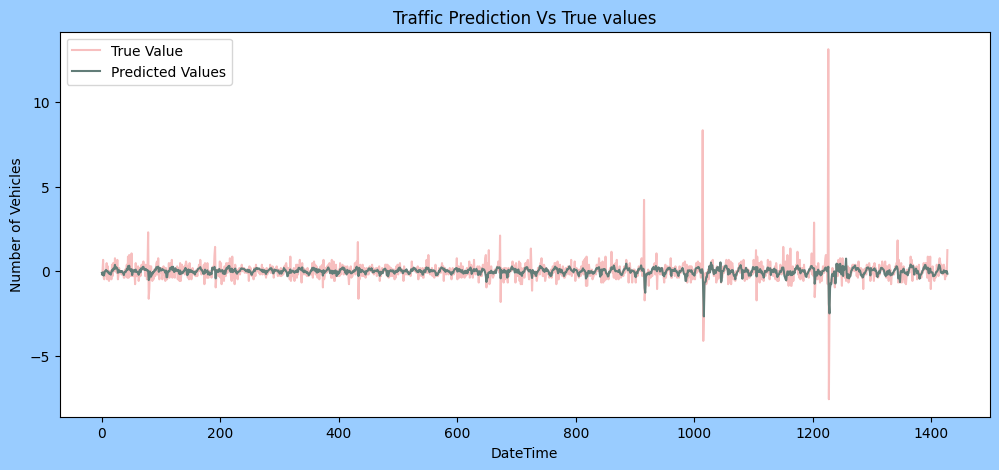

########------GRU Model------########
The root mean squared error is 0.6086876644588038.


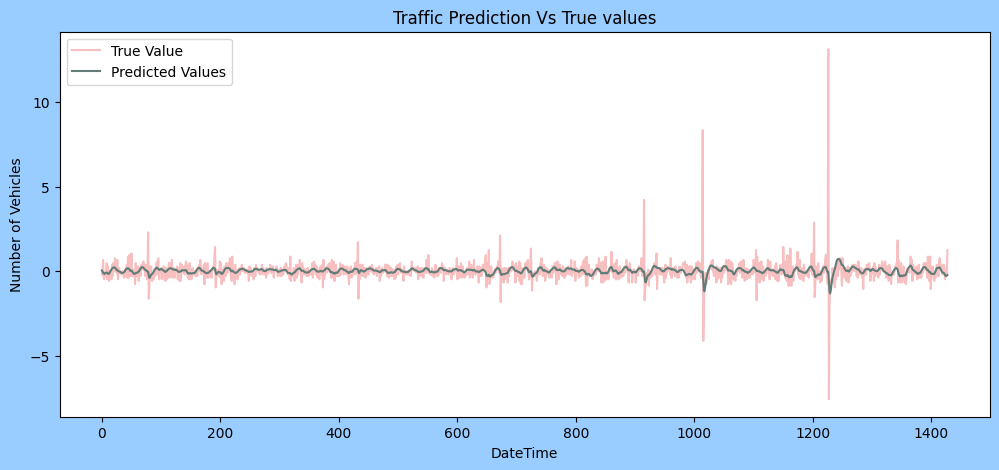


########------LSTM Model------########
The root mean squared error is 0.62004272632177.


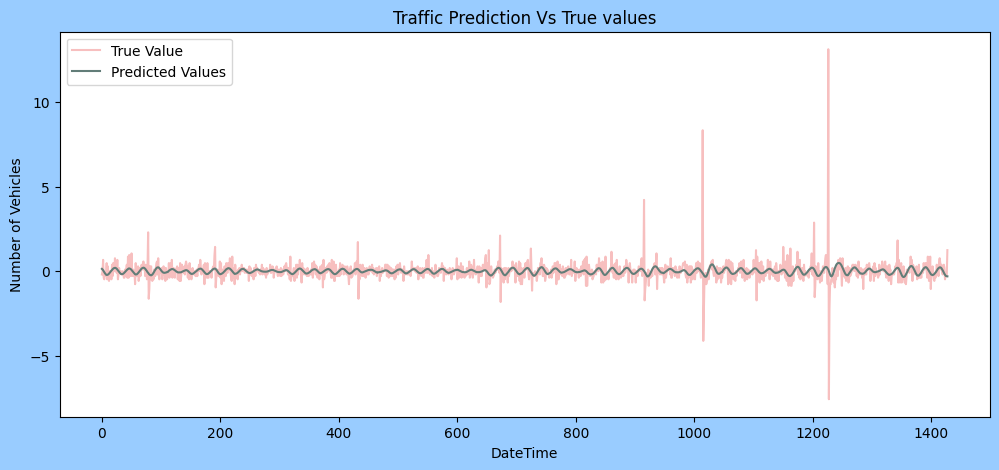


########------CNN Model------########
The root mean squared error is 0.5707588416777155.


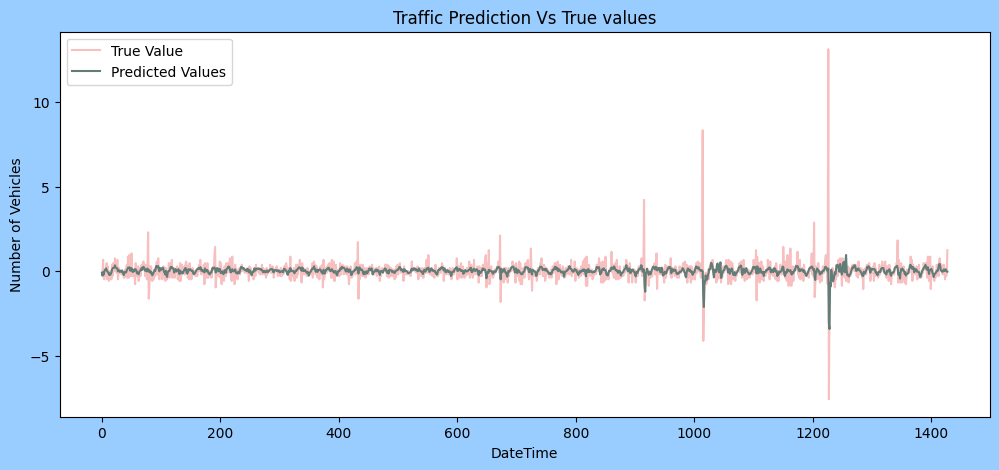


########------MLP Model------########
The root mean squared error is 0.6252613748507287.


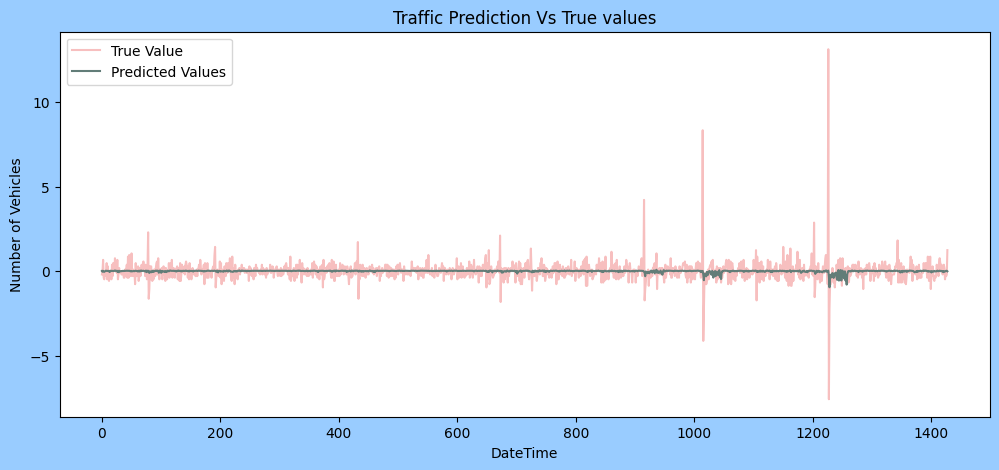


Best Model: CNN - RMSE: 0.5707588416777155



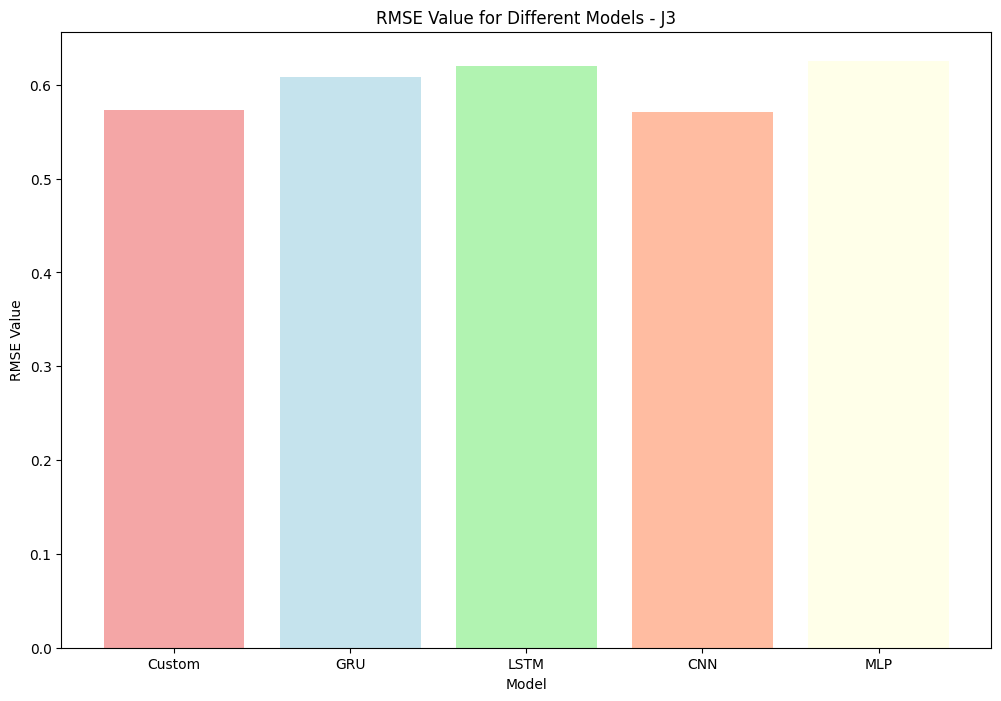

In [30]:
# Results for J3 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J3_Custom = RMSE_Value(y_testJ3, PredJ3_Custom)
PredictionsPlot(y_testJ3, PredJ3_Custom, 0)

# Results for J3 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J3_GRU = RMSE_Value(y_testJ3, PredJ3_GRU)
PredictionsPlot(y_testJ3, PredJ3_GRU, 0)

# Results for J3 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J3_LSTM = RMSE_Value(y_testJ3, PredJ3_LSTM)
PredictionsPlot(y_testJ3, PredJ3_LSTM, 0)

# Results for J3 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J3_CNN = RMSE_Value(y_testJ3, PredJ3_CNN)
PredictionsPlot(y_testJ3, PredJ3_CNN, 0)

# Results for J3 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J3_MLP = RMSE_Value(y_testJ3, PredJ3_MLP)
PredictionsPlot(y_testJ3, PredJ3_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J3_Custom, RMSE_J3_GRU, RMSE_J3_LSTM, RMSE_J3_CNN, RMSE_J3_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_3 = model_names[best_model_index]
best_model_rmse_3 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print(
    "\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(
        best_model_name_3, best_model_rmse_3
    )
)

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ["lightcoral", "lightblue", "lightgreen", "lightsalmon", "lightyellow"]
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel("Model")
ax.set_ylabel("RMSE Value")
ax.set_title("RMSE Value for Different Models - J3")
plt.show()

display(styled_df)

In [31]:
# Predictions For Fourth Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ4_Custom = Custom_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ4_GRU = GRU_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ4_LSTM = LSTM_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ4_CNN = CNN_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;33;2m########------MLP Model------########\033[0m")
PredJ4_MLP = MLP_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)

########------Custom Model------########
Epoch 1/50
33/33 [==============================] - 1s 10ms/step - loss: 0.6871 - val_loss: 1.1294
Epoch 2/50
33/33 [==============================] - 0s 5ms/step - loss: 0.6355 - val_loss: 1.0736
Epoch 3/50
33/33 [==============================] - 0s 4ms/step - loss: 0.5866 - val_loss: 1.0541
Epoch 4/50
33/33 [==============================] - 0s 4ms/step - loss: 0.5670 - val_loss: 1.0213
Epoch 5/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5540 - val_loss: 1.0052
Epoch 6/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5337 - val_loss: 1.0298
Epoch 7/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5234 - val_loss: 1.0312
Epoch 8/50
33/33 [==============================] - 0s 4ms/step - loss: 0.5101 - val_loss: 1.0179
Epoch 9/50
33/33 [==============================] - 0s 4ms/step - loss: 0.5094 - val_loss: 1.0067
Epoch 10/50
33/33 [==============================] - 0s 4ms/step - loss: 0.4

########------Custom Model------########
The root mean squared error is 1.0026054839613971.


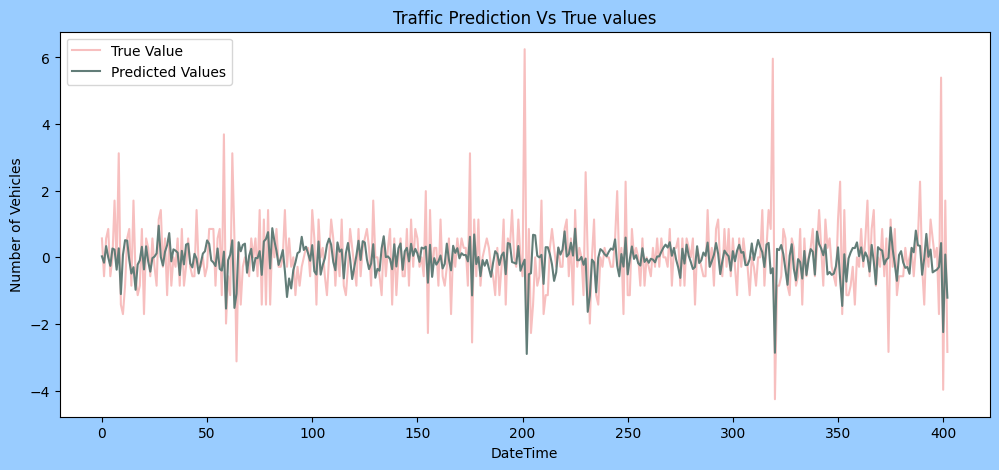

########------GRU Model------########
The root mean squared error is 0.9975154259153721.


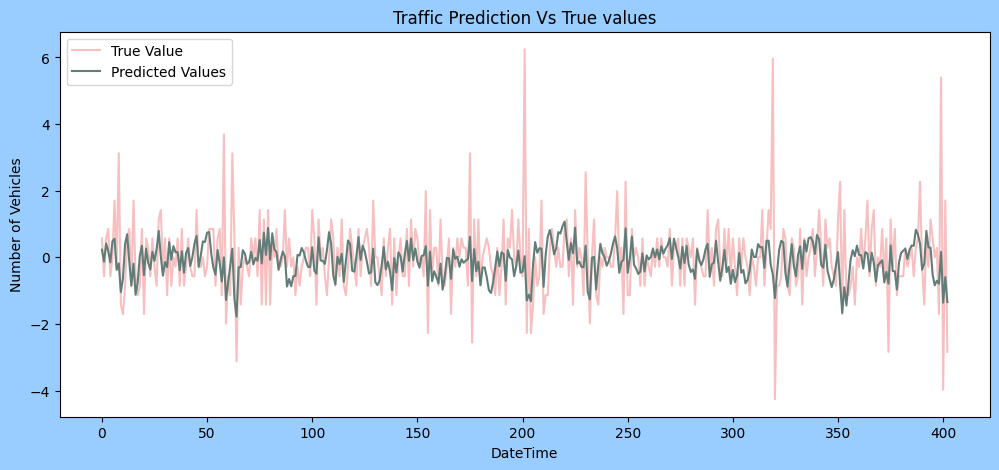


########------LSTM Model------########
The root mean squared error is 1.0961129785004553.


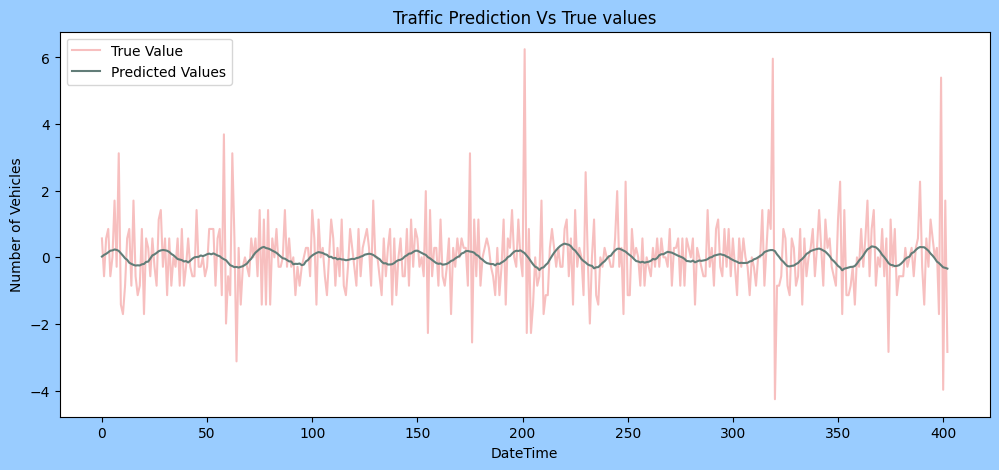


########------CNN Model------########
The root mean squared error is 0.989250150888089.


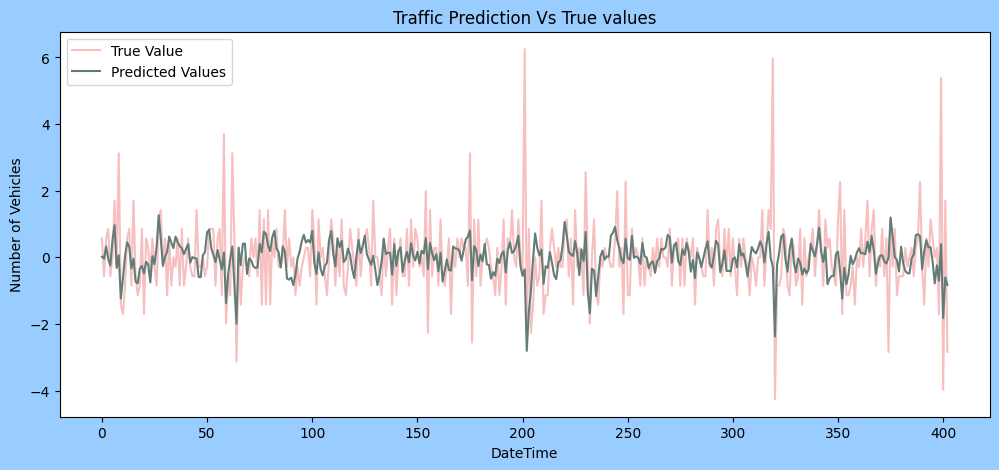


########------MLP Model------########
The root mean squared error is 1.0859716568796194.


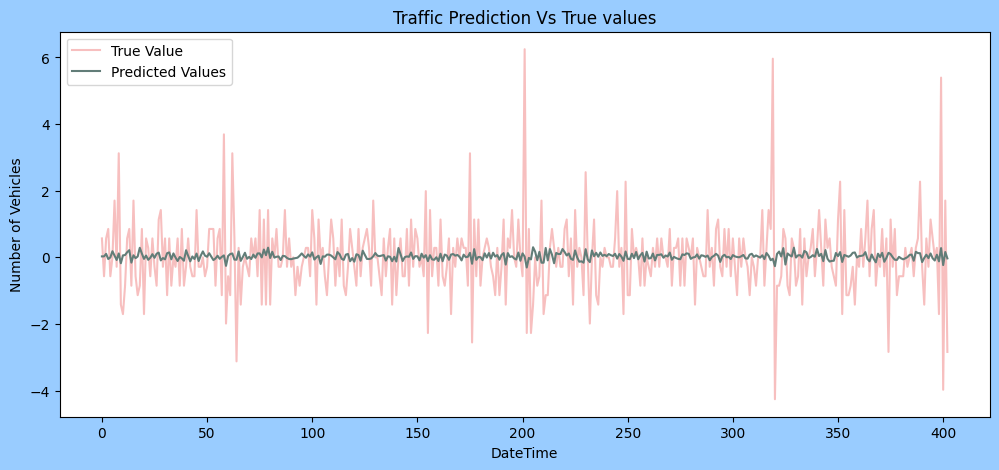


Best Model: CNN - RMSE: 0.989250150888089



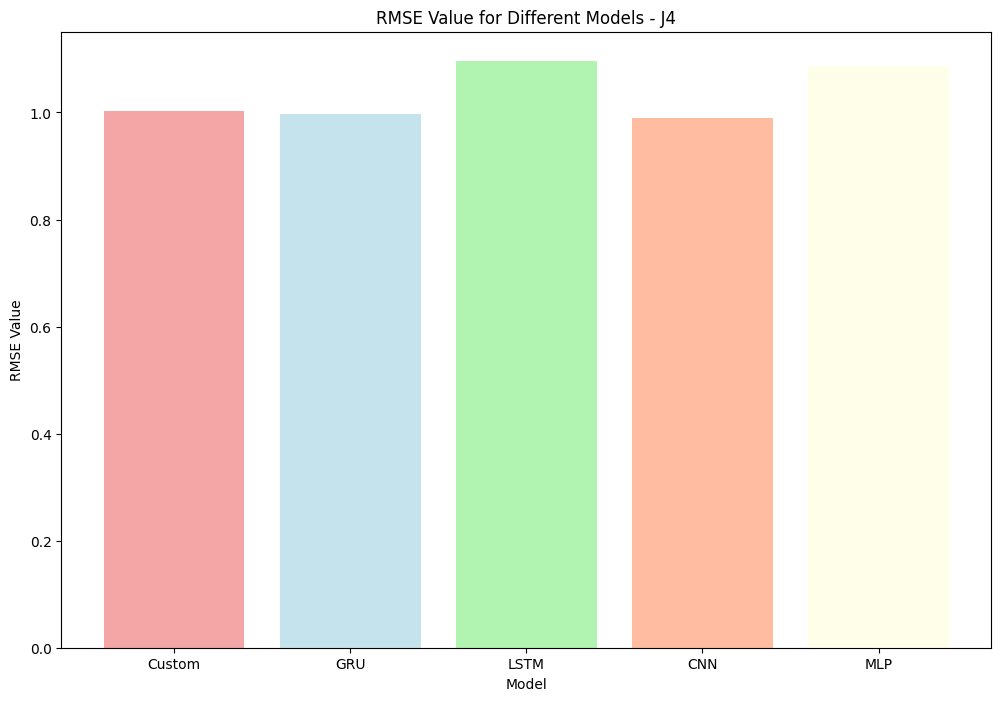

In [32]:
# Results for J4 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J4_Custom = RMSE_Value(y_testJ4, PredJ4_Custom)
PredictionsPlot(y_testJ4, PredJ4_Custom, 0)

# Results for J4 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J4_GRU = RMSE_Value(y_testJ4, PredJ4_GRU)
PredictionsPlot(y_testJ4, PredJ4_GRU, 0)

# Results for J4 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J4_LSTM = RMSE_Value(y_testJ4, PredJ4_LSTM)
PredictionsPlot(y_testJ4, PredJ4_LSTM, 0)

# Results for J4 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J4_CNN = RMSE_Value(y_testJ4, PredJ4_CNN)
PredictionsPlot(y_testJ4, PredJ4_CNN, 0)

# Results for J4 - MLP Model
print("\n\033[1;33;2m########------MLP Model------########\033[0m")
RMSE_J4_MLP = RMSE_Value(y_testJ4, PredJ4_MLP)
PredictionsPlot(y_testJ4, PredJ4_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN", "MLP"]
rmse_values = [RMSE_J4_Custom, RMSE_J4_GRU, RMSE_J4_LSTM, RMSE_J4_CNN, RMSE_J4_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_4 = model_names[best_model_index]
best_model_rmse_4 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print(
    "\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(
        best_model_name_4, best_model_rmse_4
    )
)

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ["lightcoral", "lightblue", "lightgreen", "lightsalmon", "lightyellow"]
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel("Model")
ax.set_ylabel("RMSE Value")
ax.set_title("RMSE Value for Different Models - J4")
plt.show()

display(styled_df)

**The results of the model**


In [33]:
# Initialise data of lists for error values of four junctions.
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]
RMSE = [best_model_rmse_1, best_model_rmse_2, best_model_rmse_3, best_model_rmse_4]
Model = [best_model_name_1, best_model_name_2, best_model_name_3, best_model_name_4]
list_of_tuples = list(zip(Junctions, RMSE, Model))
# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE", "MODEL"])
Results.style.background_gradient(cmap="Pastel1")

**The Root Mean Square Error is quite a subjective marker for evaluating the performance.
Thus, in this project, I am including the outcome plots as well.**


<a id="7"></a>

# <p style="background-color:#6c617d;font-family:newtimeroman;color:#D5CABD;font-size:120%;text-align:center;border-radius:20px 60px;">Inversing The Transformation Of Data</p>

In this section, I will be inversing transforms that I applied to the datasets to remove the seasonality and trends.
Performing this step will make the predictions get back on the accurate scale.

Resource to the inversion process [Link](https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/)


In [34]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed


# Plotting the comparison
def Sub_Plots2(df_1, df_2, title, m):
    fig, axes = plt.subplots(1, 2, figsize=(18, 4), sharey=True, facecolor="#99ccff")
    fig.suptitle(title)

    pl_1 = sns.lineplot(ax=axes[0], data=df_1, color=colors[m])
    axes[0].set(ylabel="Prediction")

    pl_2 = sns.lineplot(ax=axes[1], data=df_2["Vehicles"], color="#627D78")
    axes[1].set(ylabel="Orignal")

**The Inverse Transform on the first junction**


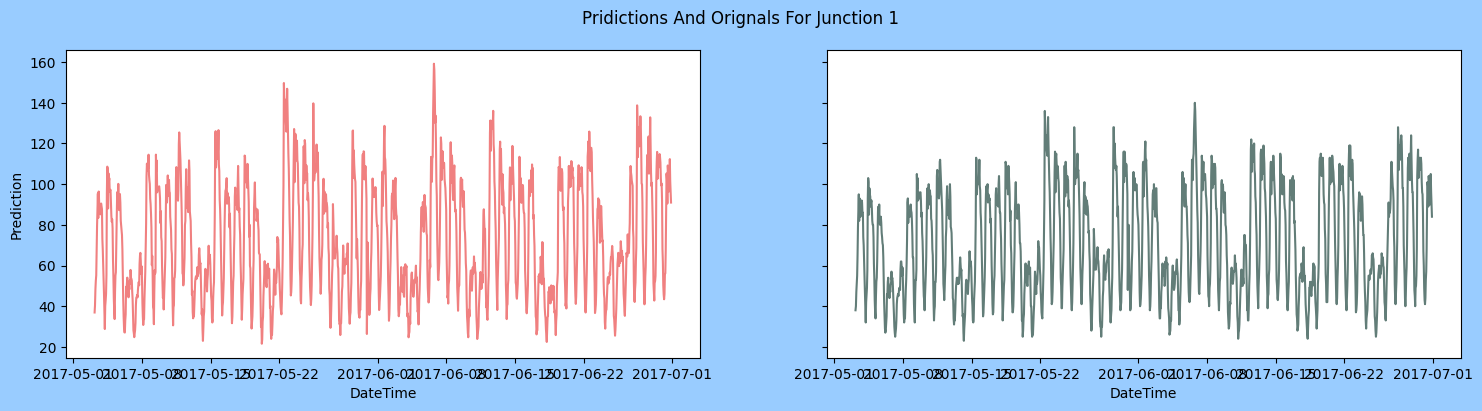

In [35]:
# invert the differenced forecast for Junction 1
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"] = globals()[f"PredJ1_{Model[0]}"]
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
# Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values * std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] = Final_J1_Pred
# Plotting the Predictions with orignals
Sub_Plots2(
    Transform_reverssed_J1["Pred_Final"],
    df_1[-1412:-1],
    "Pridictions And Orignals For Junction 1",
    0,
)

**the inverse transform on the second junction**


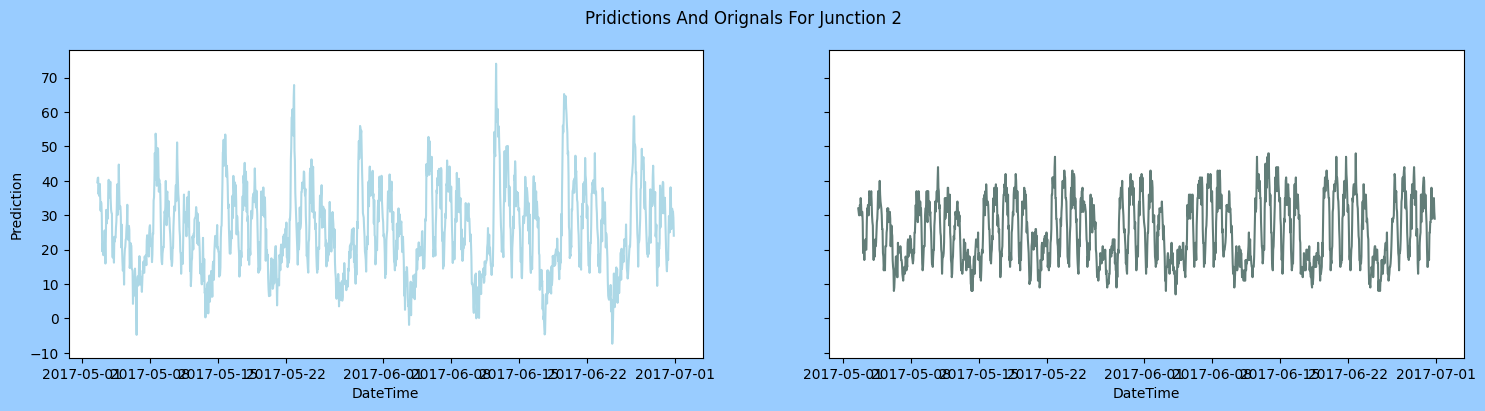

In [36]:
# Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame()  # len as per the diff
recover2["Pred"] = globals()[f"PredJ2_{Model[1]}"]
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values * std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] = Final_J2_Pred
# Plotting the Predictions with orignals
Sub_Plots2(
    Transform_reverssed_J2["Pred_Final"],
    df_2[-1426:-1],
    "Pridictions And Orignals For Junction 2",
    1,
)

**The inverse transform on the third junction**


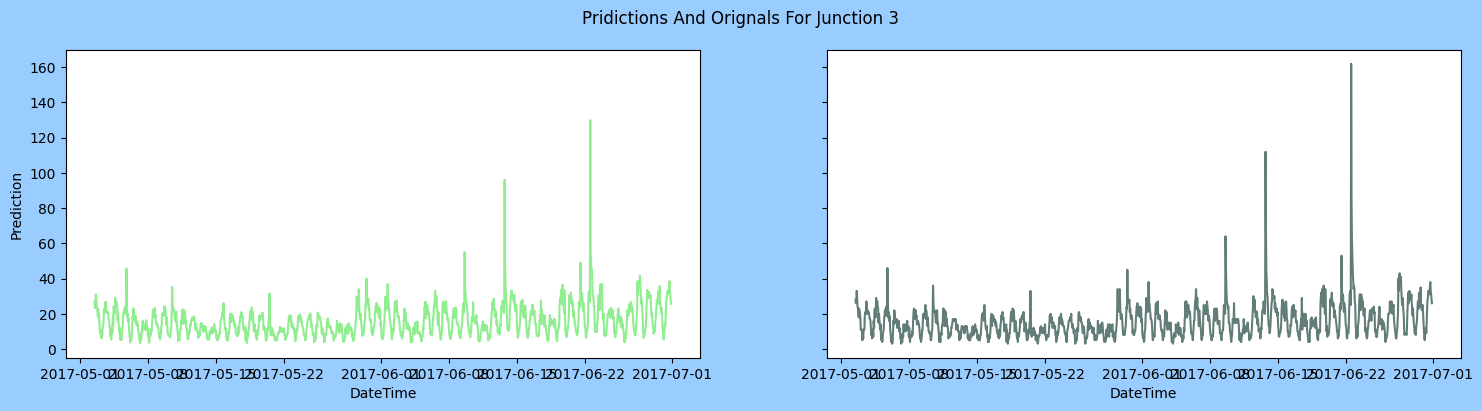

In [37]:
# Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame()  # len as per the diff
recover3["Pred"] = globals()[f"PredJ3_{Model[2]}"]
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
# Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values * std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] = Final_J3_Pred
Sub_Plots2(
    Transform_reverssed_J3["Pred_Final"],
    df_3[-1429:-1],
    "Pridictions And Orignals For Junction 3",
    2,
)

**The inverse transform on the fourth junction**


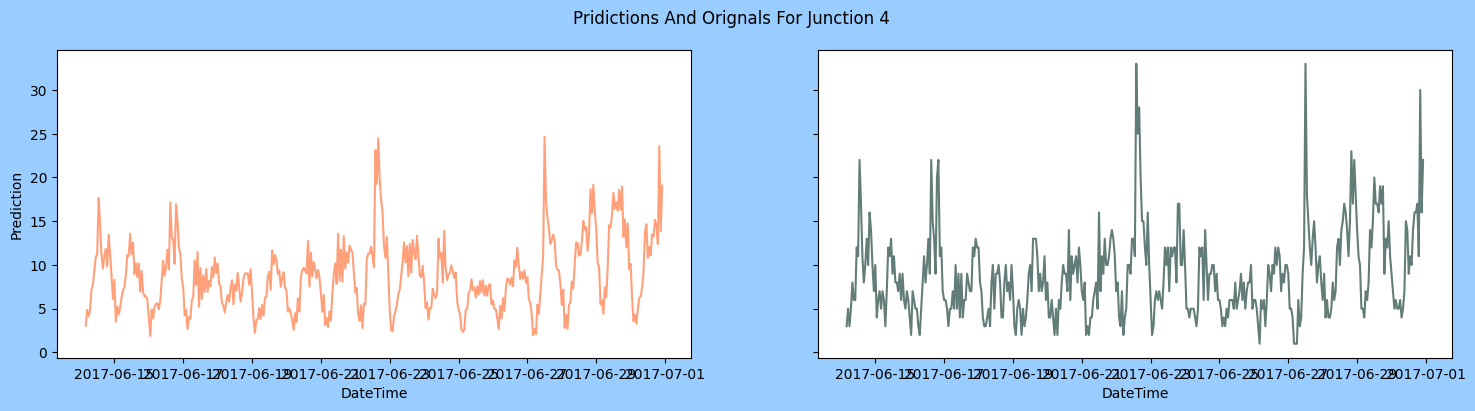

In [38]:
# Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  # len as per the testset
recover4["Pred"] = globals()[f"PredJ4_{Model[3]}"]
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
# Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values * std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] = Final_J4_Pred
Sub_Plots2(
    Transform_reverssed_J4["Pred_Final"],
    df_4[-404:-1],
    "Pridictions And Orignals For Junction 4",
    3,
)

**Summary**

_In this project, I trained a GRU, CNN, MLP, LSTM and my custom Model to predicted the traffic on four junctions.
I used a normalisation and differencing transform to achieve a stationary timeseries. As the Junctions varry in trends and seasonality, I took diffrent approach for each junction to make it stationary. I applyied the root mean squred error as the evaluation metric for the model. In addition to that I plotted the Predictions alongside the original test values.
Take aways from the data analysis:_

_The Number of vehicles in Junction one is rising more rapidly compaired to junction two and three. The sparsity of data in juction four bars me from making any conclusion on the same._

_The Junction one's traffic has a stronger weekly seasonality as well as hourly seasonality. Where as other junctions are significantly linear._

<a id="8"></a>

# <p style="background-color:#627D78;font-family:newtimeroman;color:#D5CABD;font-size:150%;text-align:center;border-radius:20px 60px;">End</p>
